Importing Required Module


In [78]:
import os
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from keras.applications import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout,BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

print("[INFO]: Tensorflow version{}".format(tf.__version__))
state_gpu = tf.test.gpu_device_name()
print("[INFO]: GPU usage{0}".format(state_gpu))

[INFO]: Tensorflow version2.12.0
[INFO]: GPU usage/device:GPU:0


Allocating file from google drive

In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Extracting Dataset

In [80]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Mango Datasets/MangoLeafBD_Dataset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

Getting Directory Path and Class Labelling

In [81]:
# getting current directory
current_directory = os.getcwd()

Mango_dataset = os.path.join(current_directory,'MangoLeafBD Dataset')
class_labels = [f for f in os.listdir(Mango_dataset) if os.path.isdir(os.path.join(Mango_dataset, f))]
class_labels

['Cutting Weevil',
 'Anthracnose',
 'Die Back',
 'Powdery Mildew',
 'Healthy',
 'Sooty Mould',
 'Gall Midge',
 'Bacterial Canker']

In [82]:
# Set the data directory and label information
data_dir = '/content/MangoLeafBD Dataset'

In [83]:
# Create a DataFrame with image paths and labels
data = []
for i, class_name in enumerate(class_labels):
    class_dir = os.path.join(data_dir, class_name)
    file_names = os.listdir(class_dir)
    for file_name in file_names:
        file_path = os.path.join(class_dir, file_name)
        label = i
        data.append((file_path, label))

df = pd.DataFrame(data, columns=['image_path', 'label'])
df['label'] = df['label'].astype(str)
df['image_path'] = df['image_path'].astype(str)
# Shuffle the data and split into train and validation sets
df = df.sample(frac=1).reset_index(drop=True)
train_split = 0.8
num_train = int(len(df) * train_split)
train_df = df[:num_train]
val_df = df[num_train:]


Showing Sample Image from Each Group

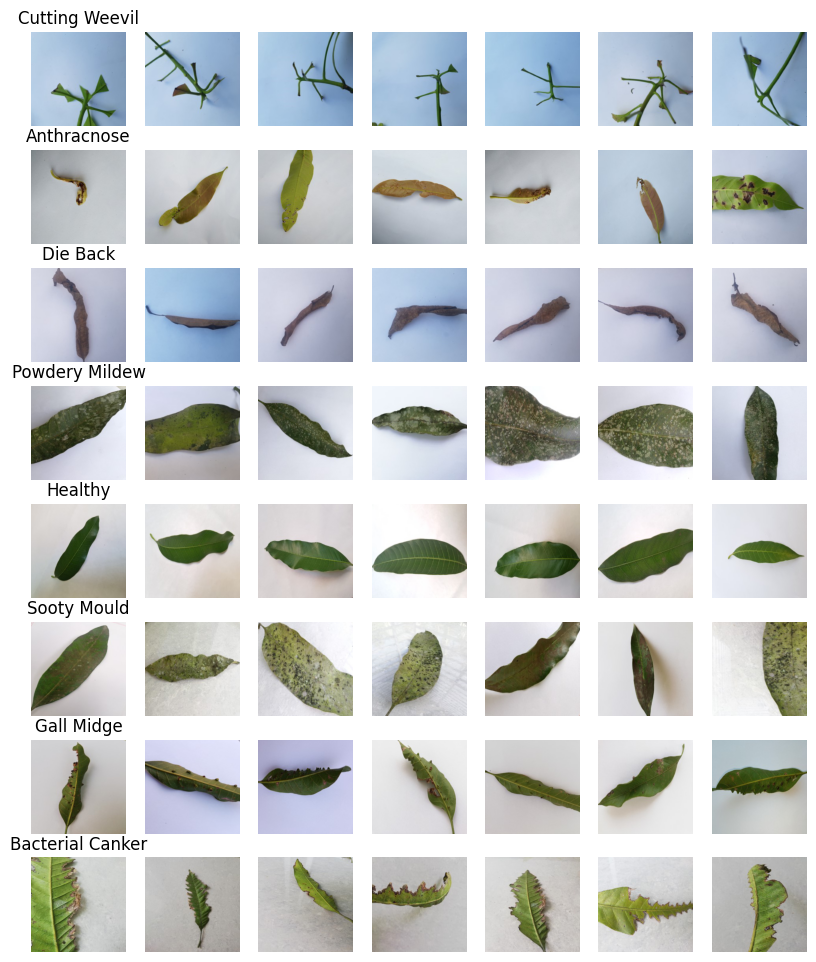

In [84]:
from PIL import Image
# Set the target size for the images
target_size = (300, 300)

# Set the number of images to display for each class
num_images = 7

# Display the images from the DataFrame
fig, axes = plt.subplots(len(class_labels), num_images, figsize=(10, 12))

for i, class_name in enumerate(class_labels):
    class_df = train_df[train_df['label'] == str(i)]
    class_samples = class_df.sample(num_images)
    
    for j, (_, row) in enumerate(class_samples.iterrows()):
        image_path = row['image_path']
        image = Image.open(image_path).resize(target_size)
        axes[i][j].imshow(image)
        axes[i][j].axis('off')
        
        if j == 0:
            axes[i][j].set_title(class_name)
        
plt.show()

Data augmentation for training and validation

In [85]:
train_datagen = ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale=1./255)

Defining image size, batch size and data generating for testing and validation

In [86]:
img_size = (224,224)
batch_size = 32

#generating data

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                     x_col='image_path',
                                                     y_col='label',
                                                     target_size=img_size,
                                                     batch_size=batch_size,
                                                     class_mode='categorical')


val_generator = val_datagen.flow_from_dataframe(dataframe=val_df,
                                                 x_col='image_path',
                                                 y_col='label',
                                                 target_size=img_size,
                                                 batch_size=batch_size,
                                                 class_mode='categorical')

Found 3200 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


1. Simple CNN model defining

In [87]:
# Build and compile a simple CNN model
model1 = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(len(class_labels), activation='softmax')
])


2. Model using VGG16

In [88]:
from keras.applications.vgg16 import VGG16
#base_model_weights_path = '/kaggle/input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = keras.layers.Flatten() (base_model_vgg16.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(8, activation='softmax')(x)
model2 = keras.models.Model(inputs=base_model_vgg16.input, outputs=output)


for layer in base_model_vgg16.layers:
    layer.trainable = False

3. Model using VGG19

In [89]:
from keras.applications.vgg19 import VGG19
base_model_vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = keras.layers.Flatten() (base_model_vgg19.output)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.25)(x)
output = keras.layers.Dense(8, activation='softmax')(x)
model3 = keras.models.Model(inputs=base_model_vgg19.input, outputs=output)


for layer in base_model_vgg19.layers:
    layer.trainable = False

4. Model using Inception V3

In [90]:
base_model_inceptionv3 = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = Flatten()(base_model_inceptionv3.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
output = Dense(len(class_labels), activation='softmax')(x)
model4 = keras.models.Model(inputs=base_model_inceptionv3.input, outputs=output)

# Freeze the base model layers
for layer in base_model_inceptionv3.layers:
    layer.trainable = False

Summary of Normal CNN model

In [91]:
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_97 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_98 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_99 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 26, 26, 128)     

Summary of VGG16

In [92]:
model2.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Summary of VGG19

In [93]:
model3.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Summary of Inception V3

In [94]:
model4.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_100 (Conv2D)            (None, 111, 111, 32  864         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_100[0][0]']             
 ormalization)                  )                                                           

Model compilation of Normal CNN

In [95]:
#model1 compilation
model1.compile(optimizer=Adam(lr = 0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model compilation of VGG16

In [96]:
#model2 compilation
model2.compile(optimizer=Adam(lr = 0.001),
               loss=keras.losses.categorical_crossentropy,
               metrics=['accuracy'])

Model compilation of VGG19

In [97]:
model3.compile(optimizer=Adam(lr = 0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Model compilation of Inception V3

In [98]:
# Compile the model
model4.compile(optimizer=Adam(lr=0.001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

Defining epochs number,step size of train and validation

In [99]:
TRAINING_NUM = train_generator.n # or train_generator.samples
VALID_NUM = val_generator.n # or val_genertor.sample
epochs = 10

STEP_SIZE_TRAIN = TRAINING_NUM // batch_size
STEP_SIZE_VALID = VALID_NUM // batch_size

Training Normal CNN model 

In [100]:
# Train the model on the training set and validate on the validation set

history1 = model1.fit(train_generator,
                      validation_data=val_generator,
                      epochs=epochs)

Epoch 1/10
100/100 [==============================] - 14s 118ms/step - loss: 1.6982 - accuracy: 0.3772 - val_loss: 1.1233 - val_accuracy: 0.6212
Epoch 2/10
100/100 [==============================] - 10s 102ms/step - loss: 0.8455 - accuracy: 0.6934 - val_loss: 0.6783 - val_accuracy: 0.7475
Epoch 3/10
100/100 [==============================] - 10s 97ms/step - loss: 0.5005 - accuracy: 0.8231 - val_loss: 0.4785 - val_accuracy: 0.8150
Epoch 4/10
100/100 [==============================] - 11s 114ms/step - loss: 0.2542 - accuracy: 0.9141 - val_loss: 0.4392 - val_accuracy: 0.8388
Epoch 5/10
100/100 [==============================] - 12s 116ms/step - loss: 0.2312 - accuracy: 0.9225 - val_loss: 0.3396 - val_accuracy: 0.8875
Epoch 6/10
100/100 [==============================] - 9s 92ms/step - loss: 0.1484 - accuracy: 0.9506 - val_loss: 0.4855 - val_accuracy: 0.8462
Epoch 7/10
100/100 [==============================] - 11s 105ms/step - loss: 0.1309 - accuracy: 0.9541 - val_loss: 0.3281 - val_accur

Training VGG16 model

In [101]:
# Fit model to get reasonable weights for newly added layers.
history2 = model2.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = val_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = epochs)

Epoch 1/10


<ipython-input-101-51c7b4a59e70>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(generator = train_generator,


100/100 [==============================] - 19s 174ms/step - loss: 0.9337 - accuracy: 0.7241 - val_loss: 0.2639 - val_accuracy: 0.9250
Epoch 2/10
100/100 [==============================] - 17s 169ms/step - loss: 0.2542 - accuracy: 0.9106 - val_loss: 0.1487 - val_accuracy: 0.9638
Epoch 3/10
100/100 [==============================] - 18s 183ms/step - loss: 0.1123 - accuracy: 0.9719 - val_loss: 0.1044 - val_accuracy: 0.9725
Epoch 4/10
100/100 [==============================] - 17s 164ms/step - loss: 0.0658 - accuracy: 0.9859 - val_loss: 0.0931 - val_accuracy: 0.9712
Epoch 5/10
100/100 [==============================] - 17s 166ms/step - loss: 0.0541 - accuracy: 0.9906 - val_loss: 0.1064 - val_accuracy: 0.9663
Epoch 6/10
100/100 [==============================] - 17s 169ms/step - loss: 0.0505 - accuracy: 0.9891 - val_loss: 0.0896 - val_accuracy: 0.9737
Epoch 7/10
100/100 [==============================] - 17s 165ms/step - loss: 0.0285 - accuracy: 0.9947 - val_loss: 0.0850 - val_accuracy: 0.9

Training VGG19 model

In [102]:
# Fit model to get reasonable weights for newly added layers.
history3 = model3.fit_generator(generator = train_generator,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_data = val_generator,
                             validation_steps = STEP_SIZE_VALID,
                             epochs = epochs)

Epoch 1/10


<ipython-input-102-4527b26b76b0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(generator = train_generator,


100/100 [==============================] - 23s 217ms/step - loss: 1.1561 - accuracy: 0.6581 - val_loss: 0.3793 - val_accuracy: 0.8925
Epoch 2/10
100/100 [==============================] - 20s 200ms/step - loss: 0.3206 - accuracy: 0.8988 - val_loss: 0.1908 - val_accuracy: 0.9525
Epoch 3/10
100/100 [==============================] - 21s 208ms/step - loss: 0.1916 - accuracy: 0.9425 - val_loss: 0.1413 - val_accuracy: 0.9600
Epoch 4/10
100/100 [==============================] - 20s 196ms/step - loss: 0.1174 - accuracy: 0.9706 - val_loss: 0.1477 - val_accuracy: 0.9488
Epoch 5/10
100/100 [==============================] - 21s 209ms/step - loss: 0.1090 - accuracy: 0.9675 - val_loss: 0.1060 - val_accuracy: 0.9700
Epoch 6/10
100/100 [==============================] - 20s 198ms/step - loss: 0.0940 - accuracy: 0.9741 - val_loss: 0.1054 - val_accuracy: 0.9600
Epoch 7/10
100/100 [==============================] - 21s 209ms/step - loss: 0.0541 - accuracy: 0.9866 - val_loss: 0.1059 - val_accuracy: 0.9

Training Inception V3 model

In [103]:

history4 = model4.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=val_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=epochs)

Epoch 1/10


<ipython-input-103-efea30e69054>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history4 = model4.fit_generator(generator=train_generator,


100/100 [==============================] - 17s 128ms/step - loss: 3.5654 - accuracy: 0.7253 - val_loss: 0.2782 - val_accuracy: 0.9200
Epoch 2/10
100/100 [==============================] - 11s 112ms/step - loss: 0.2800 - accuracy: 0.9078 - val_loss: 0.1682 - val_accuracy: 0.9438
Epoch 3/10
100/100 [==============================] - 11s 113ms/step - loss: 0.1999 - accuracy: 0.9366 - val_loss: 0.1672 - val_accuracy: 0.9513
Epoch 4/10
100/100 [==============================] - 12s 115ms/step - loss: 0.1447 - accuracy: 0.9516 - val_loss: 0.1762 - val_accuracy: 0.9450
Epoch 5/10
100/100 [==============================] - 12s 117ms/step - loss: 0.1036 - accuracy: 0.9650 - val_loss: 0.1350 - val_accuracy: 0.9575
Epoch 6/10
100/100 [==============================] - 11s 115ms/step - loss: 0.0730 - accuracy: 0.9753 - val_loss: 0.1284 - val_accuracy: 0.9675
Epoch 7/10
100/100 [==============================] - 11s 111ms/step - loss: 0.0862 - accuracy: 0.9700 - val_loss: 0.1482 - val_accuracy: 0.9

Model1 Evalution

In [104]:
# Evaluate the model on the validation set
val_loss1, val_acc1 = model1.evaluate(val_generator)
print(f'Model 1 Validation loss: {val_loss1*100:.2f}%, Validation accuracy: {val_acc1*100:.2f}%')

25/25 [==============================] - 2s 71ms/step - loss: 0.3728 - accuracy: 0.8675
Model 1 Validation loss: 37.28%, Validation accuracy: 86.75%


Model 2 Evalution

In [105]:
# Evaluate the model on the validation set
val_loss2, val_acc2 = model2.evaluate(val_generator)
print(f'Model 2 Validation loss: {val_loss2*100:.2f}%, Validation accuracy: {val_acc2*100:.2f}%')

25/25 [==============================] - 3s 132ms/step - loss: 0.0862 - accuracy: 0.9737
Model 2 Validation loss: 8.62%, Validation accuracy: 97.37%


Model3 Evalution

In [106]:
# Evaluate the model on the validation set
val_loss3, val_acc3 = model3.evaluate(val_generator)
print(f'Model 1 Validation loss: {val_loss3*100:.2f}%, Validation accuracy: {val_acc3*100:.2f}%')

25/25 [==============================] - 4s 160ms/step - loss: 0.1118 - accuracy: 0.9600
Model 1 Validation loss: 11.18%, Validation accuracy: 96.00%


Model4 Evalution

In [107]:
# Evaluate the model on the validation set
val_loss4, val_acc4 = model4.evaluate(val_generator)
print(f'Model 1 Validation loss: {val_loss4*100:.2f}%, Validation accuracy: {val_acc4*100:.2f}%')

25/25 [==============================] - 2s 88ms/step - loss: 0.1099 - accuracy: 0.9688
Model 1 Validation loss: 10.99%, Validation accuracy: 96.88%


Saving All Model

In [108]:
from keras.models import Model

# Save the model
model1.save('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model1.h5')

model2.save('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model2.h5')
model3.save('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model3.h5')
model4.save('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model4.h5')

Comparing of all model accuracy vs validation accuracy

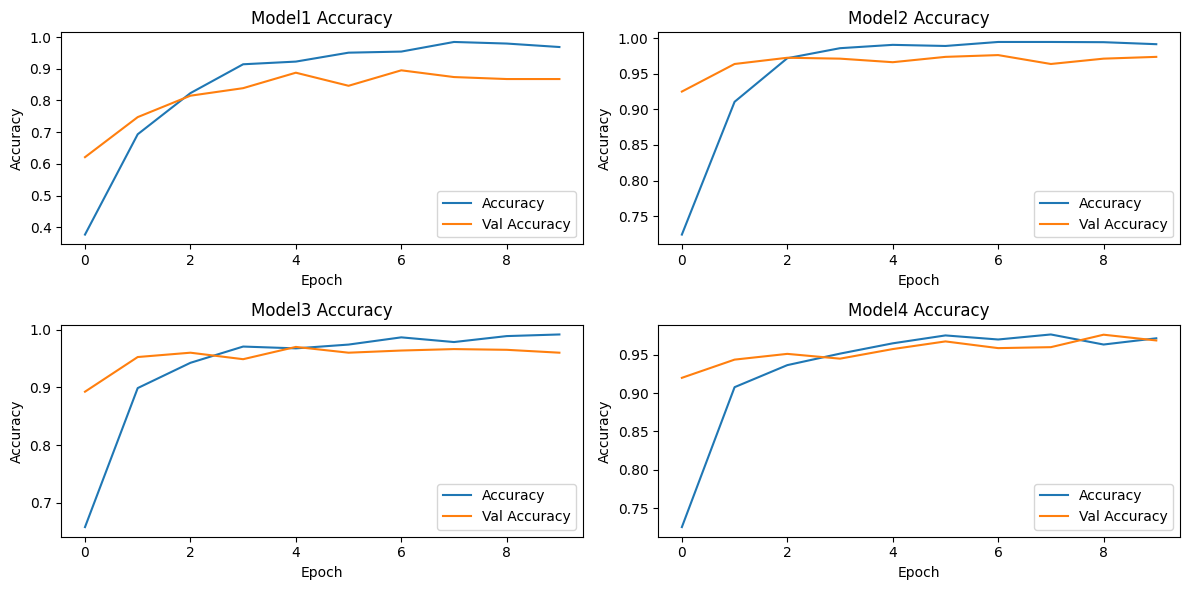

In [109]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot 1 - Model 1
axes[0, 0].plot(history1.history['accuracy'])
axes[0, 0].plot(history1.history['val_accuracy'])
axes[0, 0].set_title('Model1 Accuracy')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(['Accuracy', 'Val Accuracy'])

# Plot 2 - Model 2
axes[0, 1].plot(history2.history['accuracy'])
axes[0, 1].plot(history2.history['val_accuracy'])
axes[0, 1].set_title('Model2 Accuracy')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend(['Accuracy', 'Val Accuracy'])

# Plot 3 - Model 3
axes[1, 0].plot(history3.history['accuracy'])
axes[1, 0].plot(history3.history['val_accuracy'])
axes[1, 0].set_title('Model3 Accuracy')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend(['Accuracy', 'Val Accuracy'])

# Plot 4 - Model 4
axes[1, 1].plot(history4.history['accuracy'])
axes[1, 1].plot(history4.history['val_accuracy'])
axes[1, 1].set_title('Model4 Accuracy')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend(['Accuracy', 'Val Accuracy'])

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

Comparing of all model's losses vs validation loss

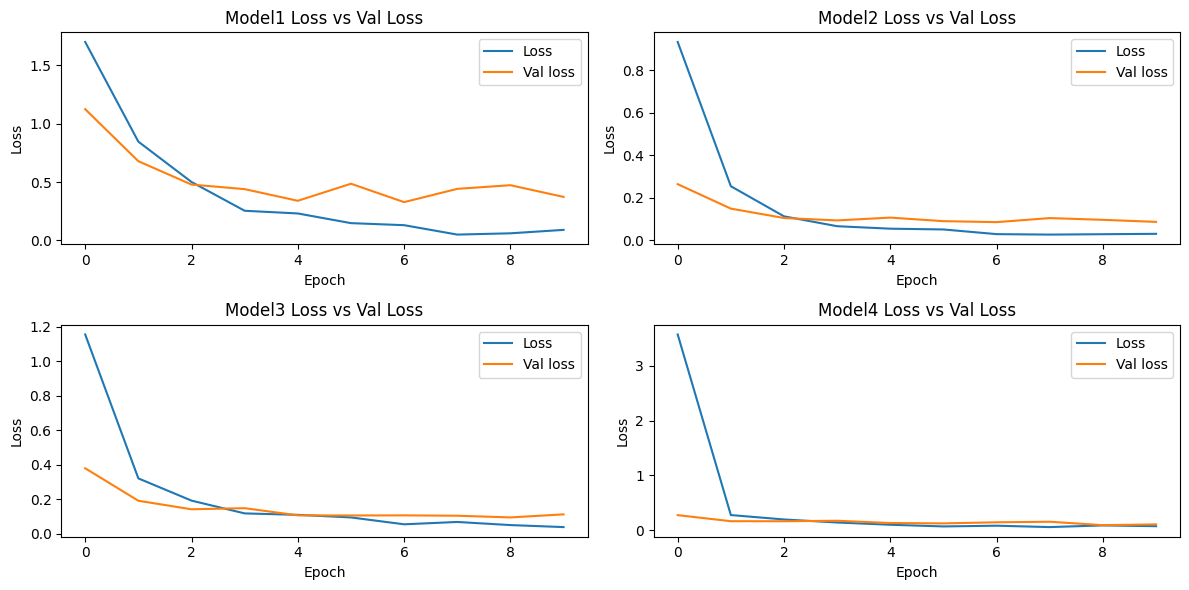

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
#plt.title('Comparison of Epochs by Loss vs val Loss')
# Plot 1 - Model 1
axes[0, 0].plot(history1.history['loss'])
axes[0, 0].plot(history1.history['val_loss'])
axes[0, 0].set_title('Model1 Loss vs Val Loss')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].legend(['Loss', 'Val loss'])

# Plot 2 - Model 2
axes[0, 1].plot(history2.history['loss'])
axes[0, 1].plot(history2.history['val_loss'])
axes[0, 1].set_title('Model2 Loss vs Val Loss')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].legend(['Loss', 'Val loss'])

# Plot 3 - Model 3
axes[1, 0].plot(history3.history['loss'])
axes[1, 0].plot(history3.history['val_loss'])
axes[1, 0].set_title('Model3 Loss vs Val Loss')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].legend(['Loss', 'Val loss'])

# Plot 4 - Model 4
axes[1, 1].plot(history4.history['loss'])
axes[1, 1].plot(history4.history['val_loss'])
axes[1, 1].set_title('Model4 Loss vs Val Loss')
axes[1, 1].set_ylabel('Loss')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].legend(['Loss', 'Val loss'])

plt.tight_layout()  # Optional - adjust spacing between subplots
plt.show()


Printing keys to check how it showing error<br>
after printing this i see that there is no keys in model1.history.history.keys()<br>
then the last one is working good.

In [111]:
print(model1.history.history.keys())
print(history1.history.keys())

dict_keys([])
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


Model bar compare

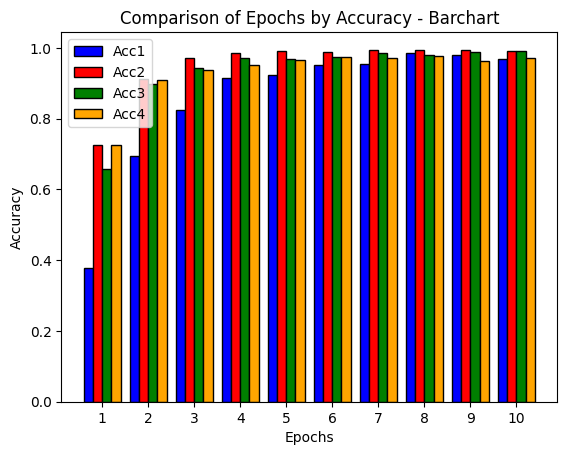

In [112]:
categories = [i for i in range(1, 11)]
accuracy1 = history1.history['accuracy']
accuracy2 = history2.history['accuracy']
accuracy3 = history3.history['accuracy']
accuracy4 = history4.history['accuracy']

# Set the width of each bar
barWidth = 0.2

# Set the positions of the bars on the x-axis
r1 = np.arange(len(categories))
r2 = [x + barWidth for x in r1]
r3 = [x + 2 * barWidth for x in r1]
r4 = [x + 3 * barWidth for x in r1]

# Create a grouped bar plot
plt.bar(r1, accuracy1, color='blue', width=barWidth, edgecolor='black', label='Acc1')
plt.bar(r2, accuracy2, color='red', width=barWidth, edgecolor='black', label='Acc2')
plt.bar(r3, accuracy3, color='green', width=barWidth, edgecolor='black', label='Acc3')
plt.bar(r4, accuracy4, color='orange', width=barWidth, edgecolor='black', label='Acc4')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Comparison of Epochs by Accuracy - Barchart')
plt.xticks([r + 1.5 * barWidth for r in range(len(categories))], categories)

# Add a legend
plt.legend()

# Show the plot
plt.show()


Accuracy Score comparing of 4 model

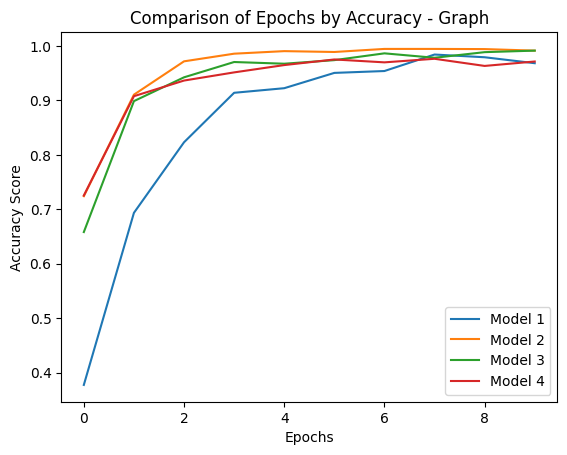

In [113]:
plt.title('Comparison of Epochs by Accuracy - Graph')
plt.plot(history1.history['accuracy'],label='Model 1')
plt.plot(history2.history['accuracy'],label='Model 2')
plt.plot(history3.history['accuracy'],label='Model 3')
plt.plot(history4.history['accuracy'],label='Model 4')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()

Saving all model for next use

In [114]:
# Save history object using pickle


# Save history1 object
with open('history1.pkl', 'wb') as f:
    pickle.dump(history1.history, f)

# Save history2 object
with open('history2.pkl', 'wb') as f:
    pickle.dump(history2.history, f)

# Save history3 object
with open('history3.pkl', 'wb') as f:
    pickle.dump(history3.history, f)

# Save history4 object
with open('history4.pkl', 'wb') as f:
    pickle.dump(history4.history, f)



Saving file to the Drive in My History Model folder

In [115]:
import shutil

# Define the source directory path
source_dir = '/content/'

# Define the destination directory path on Google Drive
destination_dir = '/content/drive/MyDrive/Mango Datasets/History Model 2'

# Copy history files to the destination directory
shutil.copy(source_dir + 'history1.pkl', destination_dir)
shutil.copy(source_dir + 'history2.pkl', destination_dir)

shutil.copy(source_dir + 'history3.pkl', destination_dir)
shutil.copy(source_dir + 'history4.pkl', destination_dir)


'/content/drive/MyDrive/Mango Datasets/History Model 2/history4.pkl'

Load model to the working /content/ of colab platform

In [116]:

# Define the source directory path on Google Drive
source_dir = '/content/drive/MyDrive/Mango Datasets/History Model/'

# Define the destination directory path in Colab content
destination_dir = '/content/'

# Move history files to the destination directory
shutil.copy(source_dir + 'history1.pkl', destination_dir)
shutil.copy(source_dir + 'history2.pkl', destination_dir)

shutil.copy(source_dir + 'history3.pkl', destination_dir)
shutil.copy(source_dir + 'history4.pkl', destination_dir)


'/content/history4.pkl'

Load history file from /content/ folder and a plot using saved model

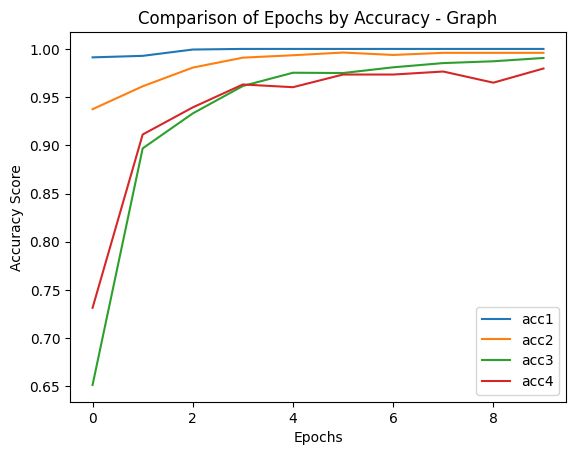

In [117]:
# Load history1 object
with open('history1.pkl', 'rb') as f:
    loaded_history1 = pickle.load(f)

# Load history2 object
with open('history2.pkl', 'rb') as f:
    loaded_history2 = pickle.load(f)

# Load history3 object
with open('history3.pkl', 'rb') as f:
    loaded_history3 = pickle.load(f)

# Load history4 object
with open('history4.pkl', 'rb') as f:
    loaded_history4 = pickle.load(f)

# Plot each history object
plt.plot(loaded_history1['accuracy'], label='acc1')
plt.plot(loaded_history2['accuracy'], label='acc2')

plt.plot(loaded_history3['accuracy'], label='acc3')
plt.plot(loaded_history4['accuracy'], label='acc4')

plt.title('Comparison of Epochs by Accuracy - Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()


Loading model with different way

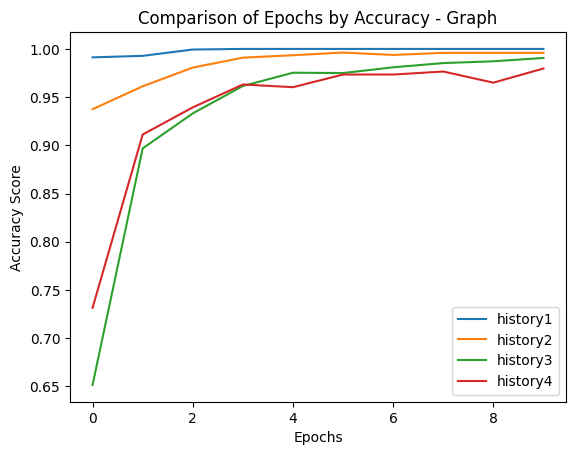

In [118]:
# Define the directory path containing the history pickle files
directory = '/content/drive/MyDrive/Mango Datasets/History Model/'

# Initialize a dictionary to store loaded histories
loaded_histories = {}

# Iterate over the pickle files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.pkl'):
        # Load each history object
        with open(os.path.join(directory, filename), 'rb') as f:
            history_name = filename.split('.')[0]
            loaded_histories[history_name] = pickle.load(f)

# Plot each loaded history object
for history_name, history_data in loaded_histories.items():
    plt.plot(history_data['accuracy'], label=history_name)

plt.title('Comparison of Epochs by Accuracy - Graph')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Score')
plt.legend()
plt.show()

Load the saved model from drive


In [122]:
from keras.models import load_model
import cv2
# Load the model
loaded_model1 = load_model('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model1.h5')
loaded_model2 = load_model('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model2.h5')
loaded_model3 = load_model('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model3.h5')
loaded_model4 = load_model('/content/drive/MyDrive/Mango Datasets/ModelWithH5/model4.h5')


Prediction for 8 different classes

In [126]:

# Load and preprocess the image
for i in range(1,9):
    image_path = '/content/drive/MyDrive/Mango Datasets/Check/mango'+str(i)+'.jpg'; 
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224, 224))
    image = image / 255.0
    image = np.expand_dims(image, axis=0)

    # Make predictions
    predictions1 = loaded_model1.predict(image)
    predictions2 = loaded_model2.predict(image)
    predictions3 = loaded_model3.predict(image)
    predictions4 = loaded_model4.predict(image)

    # Get the predicted class
    predicted_class_index1 = np.argmax(predictions1)
    predicted_class_index2 = np.argmax(predictions2)
    predicted_class_index3 = np.argmax(predictions3)
    predicted_class_index4 = np.argmax(predictions4)



    predicted_class1 = class_labels[predicted_class_index1]
    predicted_class2 = class_labels[predicted_class_index2]
    predicted_class3 = class_labels[predicted_class_index3]
    predicted_class4 = class_labels[predicted_class_index4]

    print("\nFor :", i)

    print("Predicted class using Model1: ", predicted_class1)
    print("Predicted class using Model2: ", predicted_class2)
    print("Predicted class using Model3: ", predicted_class3)
    print("Predicted class using Model4: ", predicted_class4)



1/1 [==============================] - 0s 36ms/step

For : 1
Predicted class using Model1:  Sooty Mould
Predicted class using Model2:  Die Back
Predicted class using Model3:  Die Back
Predicted class using Model4:  Die Back
1/1 [==============================] - 0s 42ms/step

For : 2
Predicted class using Model1:  Powdery Mildew
Predicted class using Model2:  Sooty Mould
Predicted class using Model3:  Sooty Mould
Predicted class using Model4:  Anthracnose
1/1 [==============================] - 0s 39ms/step

For : 3
Predicted class using Model1:  Sooty Mould
Predicted class using Model2:  Cutting Weevil
Predicted class using Model3:  Cutting Weevil
Predicted class using Model4:  Cutting Weevil
1/1 [==============================] - 0s 28ms/step

For : 4
Predicted class using Model1:  Healthy
Predicted class using Model2:  Powdery Mildew
Predicted class using Model3:  Powdery Mildew
Predicted class using Model4:  Powdery Mildew
1/1 [==============================] - 0s 25ms/step

For : 5